# Gliders NPP time series analysis

I will try here to make a timeseries analysis of NPP estimation from CbPM applied to gliders. I will grid and combined gliders together. Look at the mean and SD NPP transect. Resample over time to get one profile every hour. 

In [1]:
import polars as pl
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm as cmo
import glidertools as gt

In [2]:
doombar = xr.open_dataset('C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/npp_ncdf/doombar_npp.nc')
churchill = xr.open_dataset('C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/npp_ncdf/churchill_npp.nc')
nelson = xr.open_dataset('C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/npp_ncdf/nelson_npp.nc')
cabot = xr.open_dataset('C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/npp_ncdf/cabot_npp.nc')


In [3]:
def gliders_npp_to_pl(glider_npp_xr):

    data = [
        pl.Series("datetime", glider_npp_xr['time'].data),
        pl.Series("profile_index", glider_npp_xr['profile_index'].data),
        pl.Series("longitude", glider_npp_xr['longitude'].data),
        pl.Series("latitude", glider_npp_xr['latitude'].data),
        pl.Series("depth", glider_npp_xr['depth_bin'].data),
        pl.Series("fluo", glider_npp_xr['fluo_corrected'].data),
        pl.Series("bbp700", glider_npp_xr['bbp700'].data),
        pl.Series("par", glider_npp_xr['PAR_weighted'].data),
        pl.Series("mu", glider_npp_xr['mu'].data),
        pl.Series("npp", glider_npp_xr['pp'].data)]

    pl_df = pl.DataFrame(data)
    return pl_df


In [4]:
doombar_pl = gliders_npp_to_pl(doombar)
nelson_pl = gliders_npp_to_pl(nelson)
churchill_pl = gliders_npp_to_pl(churchill)
cabot_pl = gliders_npp_to_pl(cabot)


In [5]:
def add_round_hour(pl_df):

    df = pl_df.with_columns(pl.col('datetime').cast(pl.Datetime))

    # Identify the shallowest depth per profile (surface moment)
    surface_moments = (
        df.sort(['profile_index', 'depth'])
        .group_by('profile_index')
        .first()
        .select(['profile_index', 'datetime'])
    )

    # Round the surface moment's datetime to the nearest hour
    surface_moments = surface_moments.with_columns(
        (pl.col('datetime').dt.truncate('1h') + 
        (pl.col('datetime').dt.minute().ge(30)).cast(pl.Int32) * pl.duration(hours=1)).alias('profile_hour')
    )

    # Ensure profile_hour is treated as a datetime (if needed)
    surface_moments = surface_moments.with_columns(
        pl.col('profile_hour').cast(pl.Datetime)
    )

    # Extract the hour as an integer and date as a date object
    surface_moments = surface_moments.with_columns(
        pl.col('profile_hour').dt.hour().alias('hour'),
        pl.col('profile_hour').dt.date().cast(pl.Date).alias('date')
    )

    # Join the rounded hour and date back to the original DataFrame
    df = df.join(surface_moments.select(['profile_index', 'hour', 'date']), on='profile_index')

    return(df)

In [6]:
gliders = pl.concat([doombar_pl, nelson_pl, churchill_pl, cabot_pl])
gliders = add_round_hour(gliders)

In [ ]:
gliders = gliders.filter(pl.col("date") < pl.date(2024, 10, 1))
gliders.write_parquet('C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/all_gliders_npp.parquet')

<Axes: xlabel='hour', ylabel='par'>

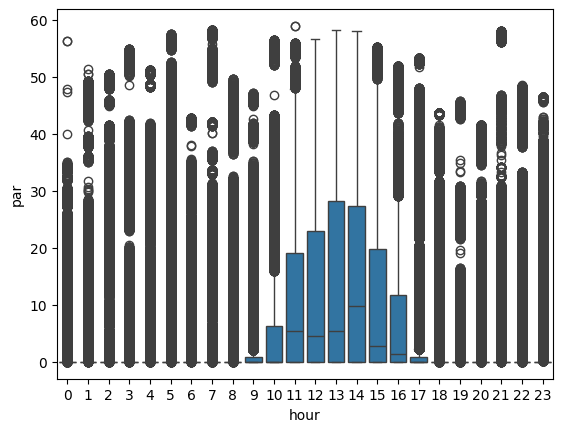

In [8]:
# library & dataset
import seaborn as sns

sns.boxplot( x=gliders["hour"], y=gliders["par"] )


In [ ]:
plt.figure(figsize=(8, 6))
#plt.plot(bbp_raw, depths, label='Backscatter Raw', color='blue')
plt.scatter(doombar_pl["bbp700"], doombar_pl["npp"], label='Par distribution')


plt.ylabel("NPP (CbPM)")
plt.title("NPP as function of PAR data")
plt.grid(True)
plt.show()

In [ ]:
prof_per_day = (
    gliders.filter(pl.col("depth") == 1)
    ).group_by(["date", "hour"]
    ).agg(pl.col("depth").mean())

In [ ]:
plt.figure(figsize=(8, 6))
#plt.plot(bbp_raw, depths, label='Backscatter Raw', color='blue')
plt.scatter(prof_per_day["date"], prof_per_day["hour"], label='N# of profile per day')

plt.ylabel("Occurence")
plt.title("Date")
plt.grid(True)
plt.show()

In [ ]:
gliders_merged = (
    gliders.group_by(["date", "hour", "depth"]
    ).agg(pl.all().mean()))

In [ ]:
all_dates = pl.Series("date", pd.date_range(gliders_merged["date"].min(), gliders_merged["date"].max()).strftime("%Y-%m-%d").tolist()).cast(pl.Date)
all_hours = pl.Series("hour", list(range(0, 24))).cast(pl.Int8)
all_depths = pl.Series("depth", list(range(0, 201)))  # Depth from 0 to 200 meters

# Create a complete grid of date-hour-depth combinations
full_grid = (
    all_dates.to_frame()
    .join(all_hours.to_frame(), how="cross")
    .join(all_depths.to_frame(), how="cross")
)

# Merge with original data to fill missing rows with NA
full_df = full_grid.join(gliders_merged, on=["date", "hour", "depth"], how="left")



In [ ]:
# Add a "status" column: "data" if an observation exists, otherwise "missing"
full_df = full_df.with_columns(
    pl.when(pl.col("profile_index").is_null())
    .then(pl.lit("missing"))
    .otherwise(pl.lit("Data"))
    .alias("status")
)

In [ ]:
plot_df = full_df.filter(pl.col("depth") == 1)

In [ ]:
plt.rcParams["figure.dpi"] = 300
 
# Use the 'hue' argument to provide a factor variable
sns.scatterplot(
   x="date",
   y="hour",
   data=plot_df,
   hue='status',
)

plt.show()

In [ ]:
numeric_cols = ["fluo", "bbp700", "par", "mu", "npp"]
full_df = full_df.with_columns(
    (pl.col("date").cast(pl.Utf8) + " " + pl.col("hour").cast(pl.Utf8) + ":00")
    .str.to_datetime("%Y-%m-%d %H:%M")
    .alias("datetime")
)
for col in numeric_cols:
    full_df = full_df.sort(["depth", "datetime"]).with_columns(
        full_df
        .group_by("depth")
        .agg(
            pl.col("datetime"),
            pl.col(col).interpolate().alias(col)  # Interpolate within each depth's timeseries
        )
        .explode(["datetime", col])  # Expand both datetime and interpolated column back into rows
    )

In [ ]:
original = full_df.filter(pl.col("status") == "data")
interpolated = full_df.filter(pl.col("status") == "missing")

In [ ]:
plot_df = full_df.filter(pl.col("npp") < 5)

In [ ]:
sns.boxplot( x=plot_df["fluo"], y=plot_df["status"] )

In [ ]:
full_df.write_parquet('C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/interpolated_npp.parquet')

In [ ]:
plt.rcParams["figure.dpi"] = 300
 
# Use the 'hue' argument to provide a factor variable
sns.scatterplot(
   x="date",
   y="depth",
   data=full_df,
   color='npp',
)

plt.show()